<a href="https://colab.research.google.com/github/Daisy-M-RGB/covidprojectCollege/blob/main/Coronavirus_Prediction_Using_Fbprophet_and_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install statsmodels --upgrade

In [3]:
pip install pmdarima

In [4]:
# importing the required libraries
import pandas as pd
import numpy as np
# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 8, 10
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
confirmed_cases = pd.read_csv('/content/drive/MyDrive/dataset/time_series_covid19_confirmed_global.csv')
deaths_reported = pd.read_csv('/content/drive/MyDrive/dataset/time_series_covid19_deaths_global.csv')
confirmed_cases.rename(columns={'Country/Region':'Country'}, inplace=True)
deaths_reported.rename(columns={'Country/Region':'Country'}, inplace=True)

In [6]:
confirmed_cases

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,59370,59576,59745,59939,60122,60300,60563,60797,61162,61455,61755,61842,62063,62403,62718,63045,63355,63412,63484,63598,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111,70761,71838,72977,74026,75119,76628,77963,79224
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,130859,130977,131085,131185,131238,131276,131327,131419,131510,131577,131666,131723,131753,131803,131845,131890,131939,131978,132015,132032,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297,132309,132315,132337,132351,132360,132372,132374,132379
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,121580,121866,122108,122311,122522,122717,122999,123272,123473,123692,123900,124104,124288,124483,124682,124889,125059,125194,125311,125485,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456,128725,128913,129218,129640,129976,130361,130681,130958
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13148,13198,13232,13232,13282,13295,13316,13340,13363,13390,13406,13423,13429,13447,13470,13470,13510,13510,13510,13555,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693,13693,13727,13729,13744,13752,13758,13758,13758
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26168,26431,26652,26815,26993,27133,27284,27529,27921,28201,28477,28740,28875,29146,29405,29695,30030,30354,30637,30787,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180,34366,34551,34752,34960,35140,35307,35594,35772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,2865,2910,2928,2942,2962,2985,2995,3030,3090,3137,3245,3412,3489,3571,3658,3740,3816,4112,4212,4359,4512,4720,4809,4941,5119,5275,5404,5931,6086,6356,6396,6908,7107,7432,7625,7870,8063,8364,8580,8791
272,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,294550,295601,296462,296462,297638,298203,298921,299736,300387,300946,301437,301751,302249,302777,303270,303270,303270,303658,303827,304074,304074,304532,304532,304968,305201,305201,305777,306334,306795,306795,307569,307838,308048,308350,308732,309036,309333,309644,309853,310026
273,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6263,6294,6317,6325,6341,6363,6390,6414,6426,6446,6462,6482,6485,6492,6498,6507,6523,6538,6543,6568,6586,6593,6613,6632,6649,6658,6662,6670,6688,6696,6723,6731,6737,6742,6751,6759,6767,6773,6780,6787
274,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91484,91533,91586,91670,91693,91722,91804,91849,91946,92004,

In [7]:
deaths_reported

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2611,2618,2625,2631,2637,2642,2648,2654,2664,2673,2683,2686,2698,2710,2713,2721,2730,2733,2742,2745,2751,2762,2772,2782,2792,2802,2812,2836,2855,2869,2881,2899,2919,2944,2973,3007,3034,3068,3104,3145
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2386,2389,2394,2396,2397,2399,2402,2403,2406,2408,2411,2412,2416,2420,2423,2426,2427,2429,2432,2435,2436,2438,2440,2441,2442,2444,2445,2447,2447,2447,2448,2449,2450,2451,2451,2451,2451,2451,2451,2451
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3234,3244,3253,3261,3270,3280,3289,3299,3307,3315,3321,3328,3335,3343,3350,3355,3360,3366,3374,3381,3388,3395,3401,3405,3411,3418,3426,3433,3440,3448,3455,3460,3465,3472,3480,3490,3497,3504,3510,3518
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,125,125,125,125,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,591,594,596,600,602,603,609,618,622,628,630,633,636,639,645,649,651,655,659,677,685,696,704,709,715,725,731,735,742,745,749,757,764,766,772,780,784,788,794,797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,NaN,Vietnam,14.058324,108.277199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,36,37,37,37,37,39,41,42,43,44,44,45,46,47,47,47,47,48,49,49,51,53,53
272,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3206,3231,3249,3249,3272,3283,3296,3317,3326,3338,3351,3358,3378,3393,3401,3401,3401,3423,3428,3437,3437,3448,3448,3452,3459,3459,3470,3480,3483,3483,3489,3492,3495,3497,3503,3507,3509,3511,3516,3517
273,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1216,1222,1226,1229,1233,1239,1240,1260,1265,1269,1270,1271,1275,1276,1277,1278,1285,1285,1289,1294,1297,1298,1301,1302,1304,1307,1310,1311,1313,1315,1316,1319,1320,1321,1322,1323,1325,1325,1325,1329
274,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1249,1250,1251,1251,1253,1253,1254,1255,1256,1256,1257,1257,1257,1258,1259,1260,1260,1260,1260,1261,1263,1263,1265,1266,1267,1268,1271,1271,1273,1275,1275,1276,1278,1281,1282,1284,1288,1297,1303,1308


merging dataframes

In [8]:
# extract dates
dates = confirmed_cases.columns[4:]
dates = deaths_reported.columns[4:]

# melt dataframes into longer format
# ==================================
confirmed_df = confirmed_cases.melt(id_vars=['Province/State', 'Country','Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df = deaths_reported.melt(id_vars=['Province/State', 'Country','Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')


print(confirmed_df.shape)
print(deaths_df.shape)

(138552, 6)
(138552, 6)


In [9]:
confirmed_df.head()

,Province/State,Country,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [10]:
confirmed_df.isnull().sum()

Province/State    95380
Country               0
Lat                1004
Long               1004
Date                  0
Confirmed             0
dtype: int64

In [11]:
deaths_df.isnull().sum()

Province/State    95380
Country               0
Lat                1004
Long               1004
Date                  0
Deaths                0
dtype: int64

In [12]:
confirmed_df.drop(['Lat', 'Long'],axis=1,inplace=True)

In [13]:
deaths_df.drop(['Lat', 'Long'],axis=1,inplace=True)

In [14]:
confirmed_df['Date'] = pd.to_datetime(confirmed_df['Date'])
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'])

In [15]:
confirmed = confirmed_df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = deaths_df.groupby('Date').sum()['Deaths'].reset_index()

In [16]:
confirmed.head()

,Date,Confirmed
0,2020-01-22,557
1,2020-01-23,655
2,2020-01-24,941
3,2020-01-25,1433
4,2020-01-26,2118


In [17]:
deaths.head()

,Date,Deaths
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56


Data Visualization

In [18]:
import plotly.express as px
import plotly.graph_objects as go

In [19]:
fig = go.Figure()
#Plotting datewise confirmed cases
fig.add_trace(go.Scatter(x=confirmed['Date'], y=confirmed['Confirmed'], mode='lines+markers', name='Confirmed',line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=deaths['Date'], y=deaths['Deaths'], mode='lines+markers', name='Deaths', line=dict(color='Red', width=2)))
fig.update_layout(title='Worldwide COVID-19 Cases', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))
fig.show()

ARIMA


In [20]:
confirmed.set_index('Date',inplace=True)
deaths.set_index('Date',inplace=True)

In [21]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

FOR CONFIRMED DATASET

In [22]:
test_result=adfuller(confirmed['Confirmed'])

In [23]:
def adfuller_test(Confirmed):
    result=adfuller(Confirmed)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [24]:
adfuller_test(confirmed['Confirmed'])

ADF Test Statistic : 0.02026333776247091
p-value : 0.9601761117089871
#Lags Used : 15
Number of Observations Used : 486
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [25]:
# Calculating the log to make the confirmed time series stationary
confirmed['adj_log'] = np.log(confirmed['Confirmed'])

In [26]:
confirmed['confirmed_log_diff'] = confirmed['adj_log']  - confirmed['adj_log'] .shift(1)

In [27]:
adfuller_test(confirmed['confirmed_log_diff'].dropna())

ADF Test Statistic : -2.98675454427855
p-value : 0.036150010944704936
#Lags Used : 17
Number of Observations Used : 483
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


FOR DEATH DATASET

In [28]:
test_result=adfuller(deaths['Deaths'])

In [29]:
def adfuller_test(Deaths):
    result=adfuller(Deaths)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [30]:
adfuller_test(deaths['Deaths'])

ADF Test Statistic : 2.5212695668177085
p-value : 0.9990563896880673
#Lags Used : 9
Number of Observations Used : 492
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [31]:
# Calculating the log to make the confirmed time series stationary
deaths['adj_log'] = np.log(deaths['Deaths'])

In [32]:
deaths['deaths_log_diff'] = deaths['adj_log']  - deaths['adj_log'] .shift(1)

In [33]:
adfuller_test(deaths['deaths_log_diff'].dropna())

ADF Test Statistic : -3.2329855425509124
p-value : 0.018152999100318593
#Lags Used : 18
Number of Observations Used : 482
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


APPLYING ARIMA MODEL

In [34]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [35]:
# FOR CONFIRMED DATASET
stepwise_fit = auto_arima(confirmed['Confirmed'],trace=True,suppress_warnings=True)
#stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=12466.386, Time=0.96 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12675.502, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=12661.549, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=12645.546, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=12590.546, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=12579.015, Time=0.30 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=12411.232, Time=1.15 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=12531.768, Time=0.26 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=12383.181, Time=1.21 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=12485.929, Time=0.26 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=12374.785, Time=1.62 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=12449.639, Time=0.48 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=12383.437, Time=2.09 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=12410.423, Time=1.65 sec
 ARIMA(5,2,2)(0,0,0

In [36]:
# FOR DEATHS DATASET
stepwise_fit = auto_arima(deaths['Deaths'],trace=True,suppress_warnings=True)
#stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=10058.852, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10334.918, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10227.187, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=10051.631, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=10052.624, Time=0.29 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=10053.285, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=10055.159, Time=0.44 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=10049.445, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=10336.913, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=10050.282, Time=0.70 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=10050.487, Time=0.48 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=10229.184, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.16 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 4.238 seconds


In [37]:
from statsmodels.tsa.arima_model import ARIMA

split data into train and test set

In [38]:
print(confirmed.shape)
print(deaths.shape)

(502, 3)
(502, 3)


In [39]:
train_confirmed = confirmed.iloc[:-30]
test_confirmed = confirmed.iloc[-30:]

In [40]:
train_deaths = deaths.iloc[:-30]
test_deaths = deaths.iloc[-30:]

In [41]:
print(train_confirmed.shape,test_confirmed.shape)
print(train_deaths.shape,test_deaths.shape)

(472, 3) (30, 3)
(472, 3) (30, 3)


training the model in confirmed dataset

In [42]:
model = ARIMA(train_confirmed['Confirmed'],order=(5,2,2))
model = model.fit()
#model.summary()

make predictions on test set of confirmed dataset

In [43]:
start = len(train_confirmed)
end = len(train_confirmed)+len(test_confirmed)-1
pred_confirmed = model.predict(start=start,end=end,typ='levels')
print(pred_confirmed)

2021-05-08    1.576595e+08
2021-05-09    1.583474e+08
2021-05-10    1.590476e+08
2021-05-11    1.598229e+08
2021-05-12    1.606807e+08
2021-05-13    1.615678e+08
2021-05-14    1.624113e+08
2021-05-15    1.631724e+08
2021-05-16    1.638759e+08
2021-05-17    1.645911e+08
2021-05-18    1.653795e+08
2021-05-19    1.662485e+08
2021-05-20    1.671460e+08
2021-05-21    1.680002e+08
2021-05-22    1.687737e+08
2021-05-23    1.694913e+08
2021-05-24    1.702210e+08
2021-05-25    1.710228e+08
2021-05-26    1.719031e+08
2021-05-27    1.728109e+08
2021-05-28    1.736758e+08
2021-05-29    1.744618e+08
2021-05-30    1.751935e+08
2021-05-31    1.759377e+08
2021-06-01    1.767527e+08
2021-06-02    1.776445e+08
2021-06-03    1.785626e+08
2021-06-04    1.794383e+08
2021-06-05    1.802367e+08
2021-06-06    1.809825e+08
Freq: D, dtype: float64


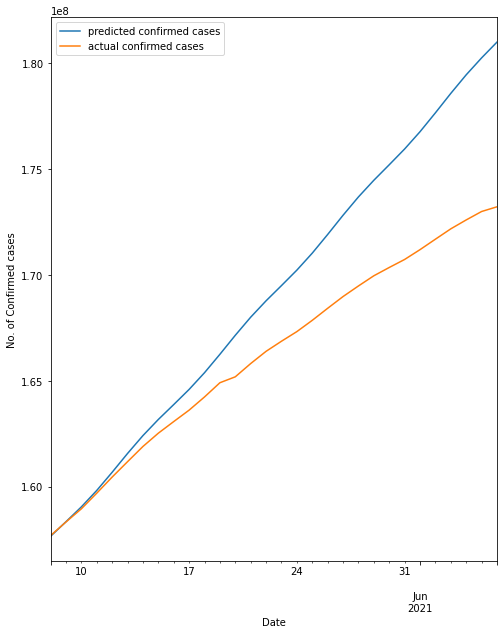

In [44]:
pred_confirmed.plot(legend=True)
test_confirmed['Confirmed'].plot(legend=True)
plt.xlabel("Date")
plt.ylabel("No. of Confirmed cases")
plt.legend(["predicted confirmed cases","actual confirmed cases"])
plt.show()

CHECKING THE R2-SCORE FOR CONFIRMED DATASET

In [45]:
score=r2_score(test_confirmed['Confirmed'],pred_confirmed)
print("r2_score is ",score)

r2_score is  0.339867968660161


training the model in deaths dataset

In [46]:
model = ARIMA(train_deaths['Deaths'],order=(0,2,1))
model = model.fit()
#model.summary()

make predictions on test set of deaths dataset

In [47]:
start = len(train_deaths)
end = len(train_deaths)+len(test_deaths)-1
pred_deaths = model.predict(start=start,end=end,typ='levels')
print(pred_deaths)

2021-05-08    3.283885e+06
2021-05-09    3.297582e+06
2021-05-10    3.311307e+06
2021-05-11    3.325062e+06
2021-05-12    3.338847e+06
2021-05-13    3.352660e+06
2021-05-14    3.366502e+06
2021-05-15    3.380374e+06
2021-05-16    3.394275e+06
2021-05-17    3.408206e+06
2021-05-18    3.422165e+06
2021-05-19    3.436154e+06
2021-05-20    3.450172e+06
2021-05-21    3.464219e+06
2021-05-22    3.478295e+06
2021-05-23    3.492401e+06
2021-05-24    3.506535e+06
2021-05-25    3.520699e+06
2021-05-26    3.534893e+06
2021-05-27    3.549115e+06
2021-05-28    3.563367e+06
2021-05-29    3.577648e+06
2021-05-30    3.591958e+06
2021-05-31    3.606297e+06
2021-06-01    3.620665e+06
2021-06-02    3.635063e+06
2021-06-03    3.649490e+06
2021-06-04    3.663946e+06
2021-06-05    3.678432e+06
2021-06-06    3.692946e+06
Freq: D, dtype: float64


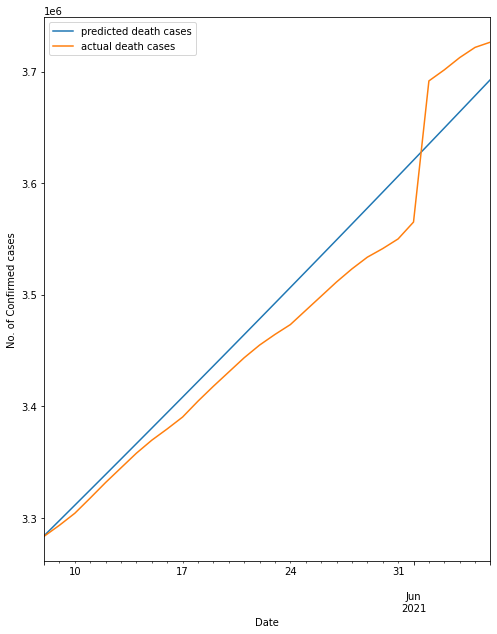

In [48]:
pred_deaths.plot(legend=True)
test_deaths['Deaths'].plot(legend=True)
plt.xlabel("Date")
plt.ylabel("No. of Confirmed cases")
plt.legend(["predicted death cases","actual death cases"])
plt.show()

CHECKING THE R2-SCORE FOR DEATH DATASET

In [49]:
score=r2_score(test_deaths['Deaths'],pred_deaths)
print("r2_score is ",score)

r2_score is  0.9374347067005159


FBPROPHET


In [50]:
confirmed_df.head()

,Province/State,Country,Date,Confirmed
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


In [51]:
deaths_df.head()

,Province/State,Country,Date,Deaths
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


In [52]:
confirmed_df['Date'] = pd.to_datetime(confirmed_df['Date'])
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'])

In [53]:
confirmed_fb = confirmed_df.groupby('Date').sum()['Confirmed'].reset_index()
deaths_fb = deaths_df.groupby('Date').sum()['Deaths'].reset_index()

In [54]:
confirmed_fb.head()

,Date,Confirmed
0,2020-01-22,557
1,2020-01-23,655
2,2020-01-24,941
3,2020-01-25,1433
4,2020-01-26,2118


In [55]:
def rename_func(dataframe):
    cols = dataframe.columns
    dataframe = dataframe.rename(columns={cols[0]:'ds', cols[1]:'y'})
    return dataframe

In [56]:
confirmed_fb= rename_func(confirmed_fb)
deaths_fb= rename_func(deaths_fb)

In [57]:
confirmed_fb.head()

,ds,y
0,2020-01-22,557
1,2020-01-23,655
2,2020-01-24,941
3,2020-01-25,1433
4,2020-01-26,2118


spliting confirmed dataset into train and test set

In [58]:
def train_test_split(dataframe, ratio):
    divisor= round((ratio/100)*dataframe.shape[0])
    train = dataframe.iloc[:divisor]
    test = dataframe.iloc[divisor:]
    return train, test, divisor

In [59]:
train_confirmed_fb, test_confirmed_fb, divisor= train_test_split(confirmed_fb,80)

In [60]:
print(train_confirmed_fb.shape,test_confirmed_fb.shape)

(402, 2) (100, 2)


In [61]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95)
model.add_seasonality(name='Monthly',period=30.42, fourier_order=5)

In [62]:
model.fit(train_confirmed_fb) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
future_confirmed = model.make_future_dataframe(periods=100) 
future_confirmed.tail()

,ds
497,2021-06-02
498,2021-06-03
499,2021-06-04
500,2021-06-05
501,2021-06-06


In [64]:
forecast_confirmed = model.predict(future_confirmed)
forecast_confirmed[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
497,2021-06-02,1.731957e+08,1.610563e+08,1.856264e+08
498,2021-06-03,1.737900e+08,1.615353e+08,1.863911e+08
499,2021-06-04,1.743886e+08,1.618288e+08,1.870656e+08
500,2021-06-05,1.750297e+08,1.619061e+08,1.880331e+08
501,2021-06-06,1.755615e+08,1.629577e+08,1.885738e+08




*   yhat= the predicted forecast
*   yhat_lower = lower border of the prediction
*   yhat_upper = upper border of the prediction








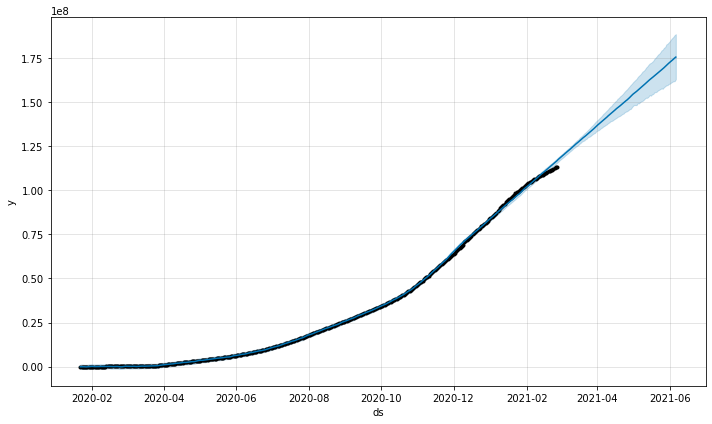

In [65]:
model.plot(forecast_confirmed);



*   black line = actual values
*   deep blue line = predicted values
*   light blue lines = boundary





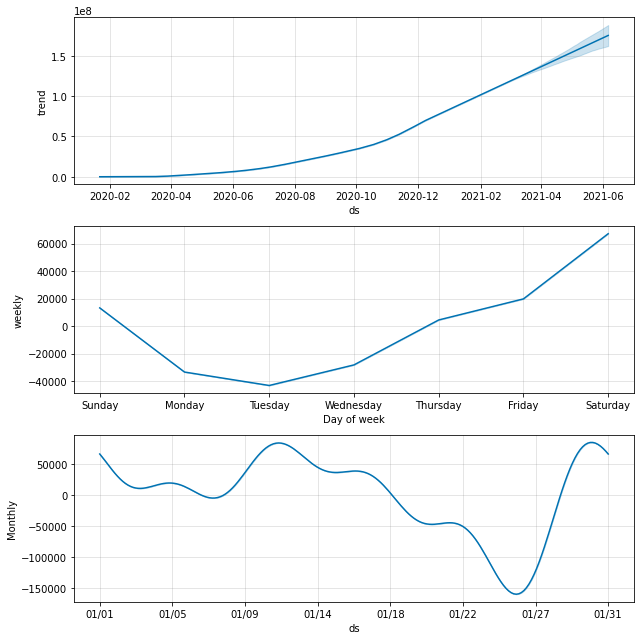

In [66]:
model.plot_components(forecast_confirmed);

In [67]:
def check_metrics(test_confirmed_fb,forecast_confirmed):
    R2_score=r2_score(test_confirmed_fb['y'],forecast_confirmed['yhat'].iloc[divisor:])
    print(f'R-square score: {R2_score}')

In [68]:
check_metrics(test_confirmed_fb,forecast_confirmed)

R-square score: 0.9367035981560301


R-square measures the proportion of variation in the dependent variable that can be attributed to the independent variable. The R-squared value R 2 is always between 0 and 1. In general, the higher the R-squared, the better the model fits your data.

spliting death dataset into train and test set

In [69]:
def train_test_split(dataframe, ratio):
    divisor= round((ratio/100)*dataframe.shape[0])
    train = dataframe.iloc[:divisor]
    test = dataframe.iloc[divisor:]
    return train, test, divisor

In [70]:
train_deaths_fb, test_deaths_fb, divisor= train_test_split(deaths_fb,80)

In [71]:
print(train_deaths_fb.shape,test_deaths_fb.shape)

(402, 2) (100, 2)


In [72]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95)
model.add_seasonality(name='Monthly',period=30.42, fourier_order=5)

In [73]:
model.fit(train_deaths_fb) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [74]:
future_deaths = model.make_future_dataframe(periods=100) 
future_deaths.tail()

,ds
497,2021-06-02
498,2021-06-03
499,2021-06-04
500,2021-06-05
501,2021-06-06


In [75]:
forecast_deaths = model.predict(future_deaths)
forecast_deaths[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
497,2021-06-02,3.735904e+06,3.427536e+06,4.051139e+06
498,2021-06-03,3.748768e+06,3.431649e+06,4.072672e+06
499,2021-06-04,3.761842e+06,3.439708e+06,4.087546e+06
500,2021-06-05,3.774551e+06,3.438633e+06,4.110389e+06
501,2021-06-06,3.785484e+06,3.451597e+06,4.120543e+06


*   yhat= the predicted forecast
*   yhat_lower = lower border of the prediction
*   yhat_upper = upper border of the prediction


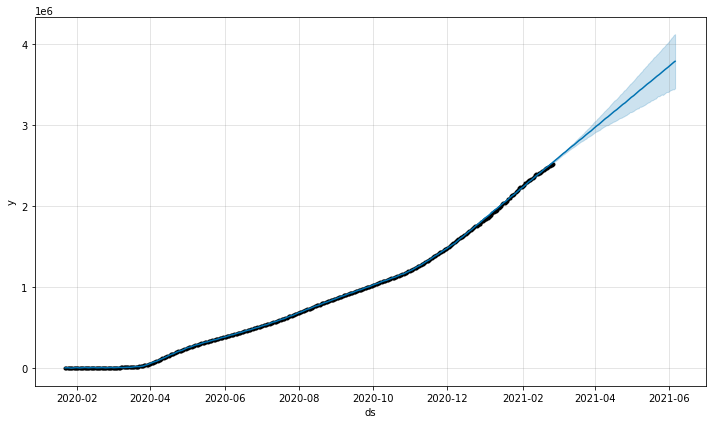

In [76]:
model.plot(forecast_deaths);

*   black line = actual values
*   deep blue line = predicted values
*   light blue lines = boundary

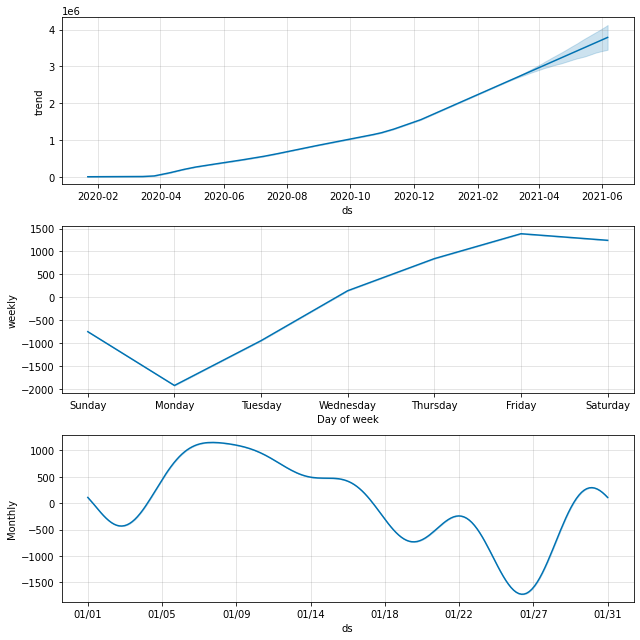

In [77]:
model.plot_components(forecast_deaths);

In [78]:
def check_metrics(test_deaths_fb,forecast_deaths):
    R2_score=r2_score(test_deaths_fb['y'],forecast_deaths['yhat'].iloc[divisor:])
    print(f'R-square score: {R2_score}')

In [79]:
check_metrics(test_deaths_fb,forecast_deaths)

R-square score: 0.8547058705436048


R-square measures the proportion of variation in the dependent variable that can be attributed to the independent variable. The R-squared value R 2 is always between 0 and 1. In general, the higher the R-squared, the better the model fits your data.

SINCE R-SQUARE MEASURE IN FBPROPHET IS MORE CLOSE TO 1 THAN R-SQUARE MEASURE IN ARIMA HENCE WE KNOW THAT FBPROPHET FITS BETTER IN OUR DATASET

now forecasting confirmed cases for the next 7 days USING FBPROPHET

In [80]:
model = Prophet(interval_width=0.95)
model.fit(confirmed_fb) 
future = model.make_future_dataframe(periods=7) 
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
504,2021-06-09
505,2021-06-10
506,2021-06-11
507,2021-06-12
508,2021-06-13


In [81]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
502,2021-06-07,1.750897e+08,1.735054e+08,1.767711e+08
503,2021-06-08,1.757302e+08,1.741416e+08,1.773291e+08
504,2021-06-09,1.764064e+08,1.746978e+08,1.781202e+08
505,2021-06-10,1.770949e+08,1.754457e+08,1.788795e+08
506,2021-06-11,1.777611e+08,1.760705e+08,1.794071e+08
507,2021-06-12,1.783930e+08,1.767428e+08,1.801626e+08
508,2021-06-13,1.789735e+08,1.772046e+08,1.807361e+08


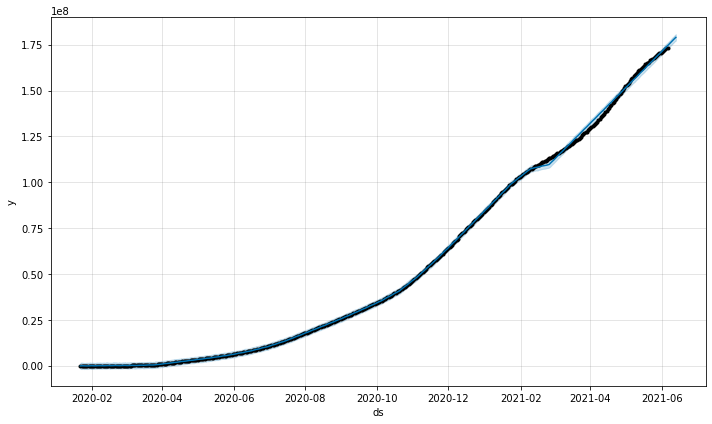

In [82]:
confirmed_forecast_plot = model.plot(forecast);

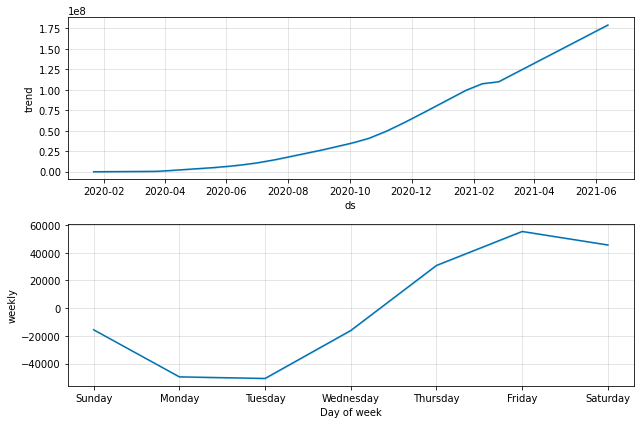

In [83]:
confirmed_forecast_plot =model.plot_components(forecast);

now forecasting death cases for the next 7 days using FBPROPHET

In [84]:
model = Prophet(interval_width=0.95)
model.fit(deaths_fb)
future = model.make_future_dataframe(periods=7)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
504,2021-06-09
505,2021-06-10
506,2021-06-11
507,2021-06-12
508,2021-06-13


In [85]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
504,2021-06-09,3.654179e+06,3.622227e+06,3.686240e+06
505,2021-06-10,3.666630e+06,3.635397e+06,3.697525e+06
506,2021-06-11,3.678787e+06,3.643282e+06,3.712447e+06
507,2021-06-12,3.689713e+06,3.656548e+06,3.722397e+06
508,2021-06-13,3.698892e+06,3.662270e+06,3.732968e+06


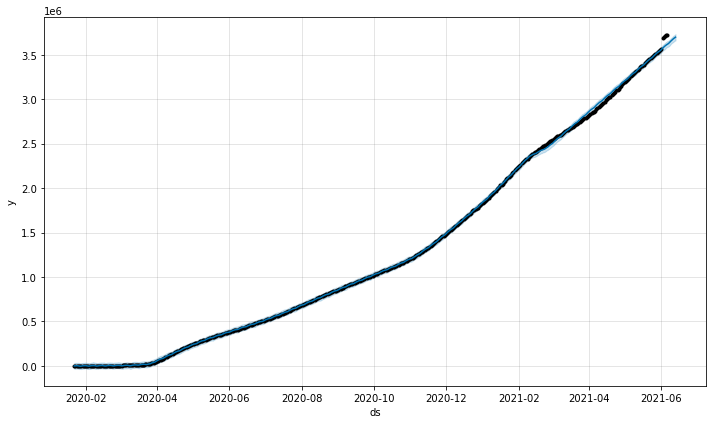

In [86]:
deaths_forecast_plot = model.plot(forecast);

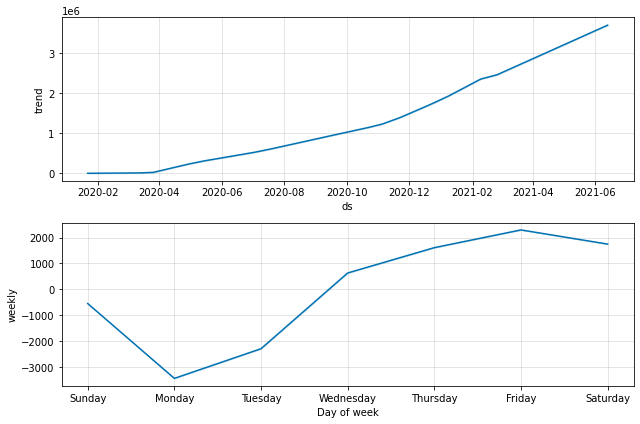

In [87]:
deaths_forecast_plot = model.plot_components(forecast);